In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
# Define dataset path
train_dir = "/content/drive/MyDrive/AI_ML/week_5/workshop_5/FruitinAmazon/train"
# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [3]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        try:
          with Image.open(img_path) as img:
            img.verify() # Verify image integrity
        except (IOError, UnidentifiedImageError):
            corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
      print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [5]:
import os

# Dictionary to store class counts
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)  # Count images in each class

# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.2600 - loss: 3.1641 - val_accuracy: 0.0667 - val_loss: 2.6357 - learning_rate: 1.0000e-04
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2284 - loss: 2.9525 - val_accuracy: 0.1333 - val_loss: 2.5130 - learning_rate: 1.0000e-04
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3524 - loss: 2.8117 - val_accuracy: 0.1333 - val_loss: 2.4007 - learning_rate: 1.0000e-04
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2615 - loss: 2.4902 - val_accuracy: 0.1333 - val_loss: 2.2887 - learning_rate: 1.0000e-04
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4260 - loss: 2.3970 - val_accuracy: 0.1667 - val_loss: 2.1787 - learning_rate: 1.0000e-04
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5071 - loss: 1.8403 - val_accuracy: 0.2000 - val_loss: 2.0822 - learning_rate: 1.0000e-04
Epoch 7/70
3/

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Re-evaluated Model Performance:
              precision    recall  f1-score   support

        acai       1.00      1.00      1.00         5
     cupuacu       1.00      0.80      0.89         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      1.00      1.00         5
     pupunha       0.83      1.00      0.91         5
      tucuma       0.80      0.80      0.80         5

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



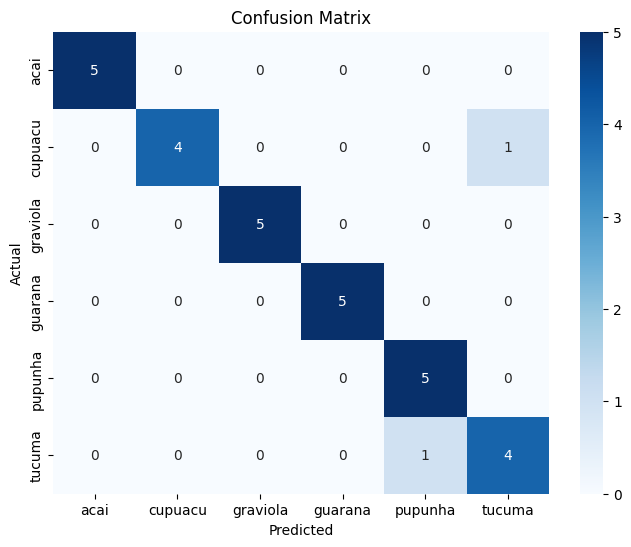

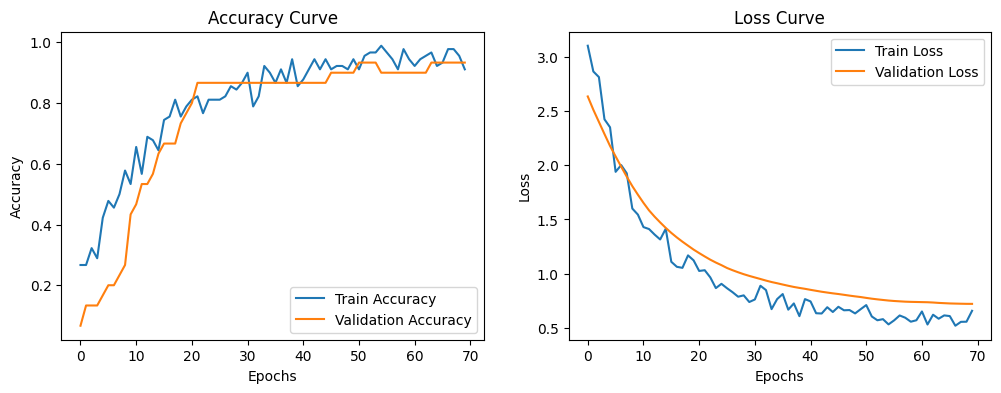

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Set dataset path
train_dir = "/content/drive/MyDrive/AI_ML/week_5/workshop_5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI_ML/week_5/workshop_5/FruitinAmazon/test"

# Image settings
img_size = (224, 224)  # Higher resolution
batch_size = 32

# Improved Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze initial layers

# Define Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train Model
history = model.fit(train_data, validation_data=test_data, epochs=70, callbacks=[early_stopping, lr_scheduler])

# Save the trained model
model.save("/content/drive/MyDrive/AI_ML/week_5/workshop_5/TenzinNorbuLama.h5")

# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/AI_ML/week_5/workshop_5/TenzinNorbuLama.h5")

# Re-evaluate the model
y_true = test_data.classes
y_pred = np.argmax(loaded_model.predict(test_data), axis=1)
class_labels = list(test_data.class_indices.keys())

print("Re-evaluated Model Performance:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Training Performance
plt.figure(figsize=(12,4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()

In [8]:
# Task 2: Transfer Learning with MobileNetV2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set image size compatible with MobileNetV2
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Prepare ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI_ML/week_5/workshop_5/FruitinAmazon/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/AI_ML/week_5/workshop_5/FruitinAmazon/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
model_tl = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# Evaluate model performance
val_loss_tl, val_acc_tl = model_tl.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc_tl:.4f}")

# Generate predictions and classification report
y_true = val_generator.classes
y_pred_probs = model_tl.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
class_labels = list(val_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

# Inference output (show first 10 predictions)
print("\nSample Inference Results:")
for i in range(10):
    print(f"True: {class_labels[y_true[i]]}, Predicted: {class_labels[y_pred[i]]}")

Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1478 - loss: 2.7978 - val_accuracy: 0.4000 - val_loss: 1.5502
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step - accuracy: 0.4994 - loss: 1.3814 - val_accuracy: 0.5333 - val_loss: 1.2475
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step - accuracy: 0.5200 - loss: 1.0721 - val_accuracy: 0.7000 - val_loss: 0.8639
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 697ms/step - accuracy: 0.8544 - loss: 0.4871 - val_accuracy: 0.8333 - val_loss: 0.6012
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9404 - loss: 0.3538 - val_accuracy: 0.8000 - val_loss: 0.5126
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 0.8000 - loss: 0.5126
Validation Accuracy: 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Classification Report:

              precision    recall  f1-score   support

        acai       0.67      0.80      0.73         5
     cupuacu       1.00      0.80      0.89         5
    graviola       0.71      1.00      0.83         5
 